#**Federated Weighted Average strategy for imbalanced datasets**

#Setup


*   Pytorch and flower installation

In [2]:
!pip install -q flwr[simulation] torch torchvision opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 38

##All General Imports

In [3]:
import os
import glob
import math
import json
import timeit
import platform

from functools import reduce
from collections import OrderedDict
from hashlib import md5
from typing import Callable, Dict, List, Optional, Tuple, Union, NewType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from opacus import PrivacyEngine
from opacus.accountants.rdp import RDPAccountant

from scipy.stats import entropy

In [4]:
# Seaborn plot settings
sns.set_style("white")
#palette = sns.color_palette("Set2")
palette = ['red','blue','green','grey','brown','violet','cyan']
sns.set_context("paper", font_scale=1.2)  # Increase font size

##All Machine Learning Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10
from torch import Tensor

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from collections import Counter, OrderedDict

##All Federated Learning Imports

In [6]:
import flwr as fl
import random

In [7]:
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitRes,
    Parameters,
    Scalar,
    NDArrays,
    parameters_to_ndarrays,
    ndarrays_to_parameters,
    MetricsAggregationFn
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import fedavg

---
**Tested with flower version 1.5.0 and torch version 2.0.1+cu118**

---



In [8]:
fl.__version__

'1.5.0'

In [9]:
torch.__version__

'2.0.1+cu118'

##Reproducibility Params

In [10]:
# For dataloader workers
def _init_fn(worker_id):
    np.random.seed(int(random_seed))


def set_random_seeds(random_seed):
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.use_deterministic_algorithms(True)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    torch.manual_seed(random_seed)

random_seed = 123
set_random_seeds(random_seed)


##All Globals

In [11]:
experiment_params = {}

In [12]:
# @title Globals { display-mode: "form" }
# @markdown Number of federated clients:
n_clients = 8 # @param {type:"slider", min:6, max:10, step:1}
loop_on_strategies = True # @param {type:"boolean"}
USE_DP = False # @param {type:"boolean"}
target_epsilon = 0.3 # @param {type:"number"}
# @markdown ---
experiment_params["n_clients"] = n_clients
experiment_params["loop_on_strategies"] = loop_on_strategies
experiment_params["USE_DP"] = USE_DP
if USE_DP:
  experiment_params["target_epsilon"] = target_epsilon

In [13]:
# @title Default strategy { display-mode: "form" }
strategy_type = 'weightedfedavg' # @param ['fedavg', 'fedadagrad', 'weightedfedavg', 'fedadam', 'fedyogi']
# @markdown ---

In [14]:
# @title #### Strategies
strategy_list = []
strategy_colors = ['red', 'green', 'blue', 'cyan', 'orange']
if loop_on_strategies:
  strategy_list = ['fedavg', 'weightedfedavg']
  #strategy_list = ['fedavg', 'weightedfedavg', 'fedadagrad', 'fedadam','fedyogi']

  # available strategies
  #strategy_list = ['fedavg', 'fedadagrad', 'weightedfedavg', 'fedadam', 'fedyogi']
  experiment_params["strategy_list"] = strategy_list
  print(strategy_list)
else:
  strategy_list = [strategy_type]
  experiment_params["strategy_type"] = strategy_type
  print(strategy_type)

['fedavg', 'weightedfedavg']


##Hyperparameters

In [15]:
# @title ### Hypers { display-mode: "form" }
n_epochs = 2 # @param {type:"slider", min:1, max:25}
n_rounds = 15 # @param {type:"slider", min:2, max:25}
batch_size = 32 # @param {type:"slider", min:32, max:128, step:32}
validation_split = 0.2
learning_rate = 0.0018673528886359607 # @param {type:"number"}
# @markdown ---
experiment_params["n_epochs"] = n_epochs
experiment_params["n_rounds"] = n_rounds
experiment_params["batch_size"] = batch_size
experiment_params["learning_rate"] = learning_rate

In [16]:
# @title ### Split method { display-mode: "form" }
# @markdown Select method:
# @markdown - majority = one majority class per client. Different sample size per client.
# @markdown - majority_even = one majority class per client. Same sample size per client.
# @markdown - pick_two = two majority class per client
# @markdown - random = random splits
method_selected = 'majority_even' # @param ['stratified', 'random', 'majority_even', 'majority', 'pick_two']
# @markdown Ratio for majority classes
# *Not all values are possible*
# @markdown **Bug:** *Not all values are possible*, it gives an error if there are not enough samples to distribute to all clients.
ratio_majority_class = 0.6 # @param {type:"slider", min:0.1, max:1, step:0.1}
test_split_size = 0.2 # @param {type:"slider", min:0.1, max:0.5, step:0.05}
# @markdown ---
experiment_params["method_selected"] = method_selected
experiment_params["ratio_majority_class"] = ratio_majority_class
experiment_params["test_split_size"] = test_split_size

In [17]:
# @title ### Weighting options { display-mode: "form" }
# @markdown Options:
# @markdown - Weighted -> using sample sizes and class frequencies
# @markdown - Standard = FedAvg
# @markdown - Arithmetic = Naive average (not weighted)
avg_strategy = 'weighted' # @param ["standard", "arithmetic", "weighted"]
# @markdown ---
experiment_params["avg_strategy"] = avg_strategy

##Initializations

In [18]:
experiment_json = json.dumps(experiment_params)

In [19]:
# @title Save path
save_path = md5(experiment_json.encode()).hexdigest()[:8]
print(save_path)

f1761825


In [20]:
# @title ### Prefix for experiment folder
prefix = "Yogi" # @param {type:"string"}

In [21]:

with open(f'{prefix}_{save_path}.json', 'w') as f:
    f.write(experiment_json)

In [22]:
start_global_time = timeit.default_timer()

if not os.path.exists(save_path):
    os.makedirs(save_path)

with open(f'{save_path}/experiment_parameters.json', 'w') as f:
    f.write(experiment_json)

DEVICE = torch.device("cpu")  # Prova "cuda" per addestramento su GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

OS = platform.system()           # Sistema Operativo

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


#Data preparation

##Data Download

In [23]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
    return True
  else:
    return None



In [24]:
out = data_download("./har_datasets_fl.zip", "1LUjU4yvBRh6FPBlIHRCD2uf5zMH6l9tC", OS)
#urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip", filename="har-data.zip")


##Data Splitting

Proposed methods:
- Majority even: a majority class will be distributed to each client $i=\{1\to \text{num classes}\}$ with a custom ratio ensuring that the splits for all clients have the same number of samples.
- Majority: as above but splits do not have the same size.
- Pick two: as the first method but distributing two "majority" classes.
- Random: distributes samples randomly to each client.

In [25]:
n_splits = n_clients

In [26]:
trainloaders = []

# Awful hack, when True this flips test and train datasets for a stratified
# split ensuring that independent balanced samples are distributed in each split
# Normal behavior flip=False
flip = False
def stratified_split(data, targets, n_splits, split_size=None):
    # NOTE: We pick one stratified split => n_splits=1 because we want a
    # balanced test set, the training part will be postprocessed
    if not split_size:
      df = pd.DataFrame(data)
      data_length = len(df)
      split_size = int(data_length / n_splits)
      print("split_size", test_size)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=split_size, random_state=random_seed)
    for train_index, val_index in sss.split(data, targets):
        if flip:
          yield data[val_index], targets[val_index], data[train_index], targets[train_index]
        else:
          yield data[train_index], targets[train_index], data[val_index], targets[val_index]

def random_split(data, targets, n_splits, split_size=None):
    if not split_size:
      split_size = 1 / n_splits
    for _ in range(n_splits):
        X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=split_size)
        yield X_train, y_train, X_val, y_val

def majority_even(data, targets, n_splits, split_size=None,
                        ratio_majority_class=ratio_majority_class):
    df = pd.DataFrame(data)
    df['Y'] = targets
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    datasets = []
    data_length = len(df)
    split_size = int(data_length / n_splits)
    class_counts = df['Y'].value_counts().to_dict()
    for cls, count in class_counts.items():
        majority_sample = df[df['Y'] == cls].sample(int(count * ratio_majority_class))
        #add second majority class for 3rd first datasets
        other_classes_sample = df[~(df['Y'] == cls)].sample(split_size - len(majority_sample))
        dataset = pd.concat([majority_sample, other_classes_sample]).sample(frac=1).reset_index(drop=True)
        datasets.append(dataset)
        used_indices = pd.Index(majority_sample.index).union(other_classes_sample.index)
        df.drop(used_indices, inplace=True)
        df.reset_index(drop=True, inplace=True)

    for _ in range(n_splits -len(datasets)):
        dataset = df.sample(split_size)
        datasets.append(dataset)
        df.drop(dataset.index, inplace=True)
        df.reset_index(drop=True, inplace=True)

    for dataset in datasets:
        X_train = dataset.drop(columns=['Y']).to_numpy()
        y_train = dataset['Y'].to_numpy()
        yield X_train, y_train, None, None

def pick_two(data, targets, n_splits, split_size=None,
                        ratio_majority_class=ratio_majority_class):
    df = pd.DataFrame(data)
    df['Y'] = targets
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    datasets = []
    data_length = len(df)
    split_size = int(data_length / n_splits)
    class_counts = df['Y'].value_counts().to_dict()
    for (cls1, count1), (cls2, count2)  in zip(list(class_counts.items())[::2],
                                               list(class_counts.items())[1::2]):
        print((cls1, count1), (cls2, count2))
        majority_sample = df[(df['Y'] == cls1) | (df['Y']==cls2)].sample(int(count1 * ratio_majority_class))
        other_classes_sample = df[~((df['Y'] == cls1) | (df['Y']==cls2))].sample(split_size - len(majority_sample))
        dataset = pd.concat([majority_sample, other_classes_sample]).sample(frac=1).reset_index(drop=True)
        datasets.append(dataset)
        used_indices = pd.Index(majority_sample.index).union(other_classes_sample.index)
        df.drop(used_indices, inplace=True)
        df.reset_index(drop=True, inplace=True)

    for _ in range(n_splits -len(datasets)):
        dataset = df.sample(split_size)
        datasets.append(dataset)
        df.drop(dataset.index, inplace=True)
        df.reset_index(drop=True, inplace=True)

    for dataset in datasets:
        X_train = dataset.drop(columns=['Y']).to_numpy()
        y_train = dataset['Y'].to_numpy()
        yield X_train, y_train, None, None

def pick_majority(data, targets, n_splits, split_size=None,
                          percent_majority_class=ratio_majority_class):
    df = pd.DataFrame(data)
    df['Y'] = targets
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    maj_datasets = []
    data_length = len(df)
    class_counts = df['Y'].value_counts().to_dict()
    for cls, count in class_counts.items():
        majority_sample = df[df['Y'] == cls].sample(int(count * ratio_majority_class))
        maj_datasets.append(majority_sample)
        used_indices = pd.Index(majority_sample.index)
        df.drop(used_indices, inplace=True)
        df.reset_index(drop=True, inplace=True)

    splits = np.array_split(df, n_splits)
    datasets = []
    for i, split in enumerate(splits):
        if i < len(np.unique(targets)):
          dataset = pd.concat([pd.DataFrame(split), maj_datasets[i]]).sample(frac=1).reset_index(drop=True)
        else:
          dataset = pd.DataFrame(split)
        datasets.append(dataset)

    for dataset in datasets:
        X_train = dataset.drop(columns=['Y']).to_numpy()
        y_train = dataset['Y'].to_numpy()
        yield X_train, y_train, None, None


SPLIT_METHODS = {
    'stratified': stratified_split,
    'random': random_split,
    'majority_even': majority_even,
    'majority': pick_majority,
    'pick_two': pick_two
}

def gini_index(y):
  uniques = np.unique(y+1, return_counts=True)
  probs = uniques[1]/np.sum(uniques[1])
  #print(uniques, probs, np.sum(probs))
  gini_index = 1.0 - np.sum(probs ** 2)
  return gini_index

def get_data_from_path(path):
    fold_number = os.path.basename(path).split('-')[0].strip()
    trainset = pd.read_csv(f"{path}/train/{fold_number}_ALL_train.csv", delimiter=';')
    testset = pd.read_csv(f"{path}/test/{fold_number}_ALL_test.csv", delimiter=';')
    return trainset, testset

def create_datasets_from_dataframe(df):
    # Extract features from columns '0' to '560'
    X = pd.concat([df[str(i)] for i in range(561)], axis=1).values
    # Adjust labels in 'Y' column to start from 0
    y = (df['Y'] - 1).values

    return X, y


def generate_dataloaders(data, targets, split_method, n_splits):
    dataloaders = []
    split_function = SPLIT_METHODS[split_method]
    gini_indices = []
    # Assuming set_random_seeds function is defined elsewhere
    set_random_seeds(random_seed)

    for i, (X_train, y_train, _, _) in\
     enumerate(split_function(data, targets, n_splits)):
        train_gini = gini_index(y_train)


        # Print distribution of classes for this fold
        class_distribution = Counter(y_train)
        print(f"Fold {i+1} size {len(y_train)} class distribution: {class_distribution}")

        gini_data = {
            'Dataset': i + 1,
            'Train Gini Index': train_gini,
        }

        gini_indices.append(gini_data)

        train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        dataloaders.append(train_loader)

    return dataloaders, gini_indices


In [27]:
# Let's combine the old data splits into a single dataframe
all_data = []
for path in [f.path for f in os.scandir('./har_datasets_fl') if f.is_dir()]:
    train_df, test_df = get_data_from_path(path)
    all_data.append(train_df)
    all_data.append(test_df)

combined_df = pd.concat(all_data, axis=0)
print(f"Total data points {len(combined_df)}")

X_all, y_all = create_datasets_from_dataframe(combined_df)

# 1st stratified to get all train data and test data for (server) evaluation
#test_size = 0.2
X_train_combined, y_train_combined, X_test, y_test =\
  next(stratified_split(X_all, y_all, n_splits=1, split_size=test_split_size))

print(f"Total train data points {len(X_train_combined)}")
print(f"Total train data points {len(X_test)}")

Total data points 10299
Total train data points 8239
Total train data points 2060


#### Baseline
The datasets for the baseline contains independent stratified balanced folds, one per client.

In [28]:
flip = True
test_size = 0.2
trainloaders_bl, gini_data_bl = \
  generate_dataloaders(X_train_combined, y_train_combined,
                       "stratified", n_splits)

gini_df = pd.DataFrame(gini_data_bl)
print(gini_df)

print("Number of Training Subsets: ", len(trainloaders_bl))

split_size 0.2
Fold 1 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 2 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 3 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 4 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 5 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 6 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 7 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
Fold 8 size 1029 class distribution: Counter({5: 194, 4: 190, 3: 178, 0: 172, 1: 154, 2: 141})
   Dataset  Train Gini Index
0        1          0.831324
1        2          0.831324
2        3          0.831324
3        4          0.831324
4        5          0.831324
5        6          0.831324
6        7          0.

In [29]:
# number of classes
n_classes = len(np.unique(y_train_combined))
# Assuming class_names is a dictionary mapping class numbers to class names
class_names = {0: "Walking", 1: "Walking\nupstairs", 2: "Walking\ndownstairs", 3: "Sitting", 4: "Standing", 5: "Laying"}

In [30]:
def plot_classes(trainloaders):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  ax1.set_title("Classes distributions")
  offset=-0.4
  counts_per_client = [pd.DataFrame(np.concatenate(tuple([y.numpy() for x, y  in t])), columns=["class"]).value_counts() for t in trainloaders]

  df = pd.concat([pd.DataFrame(ser).assign(client=i) for i, ser in enumerate(counts_per_client)]).reset_index().sort_values(by=["client", "class"]).replace({'class': class_names})

  ax2.set_title("Client distributions")
  sns.barplot(x="class", y=0, hue="client", data=df, ax=ax1)
  ax1.set_ylabel("Counts")
  ax1.set_xlabel("Classes")
  sns.barplot(x="client", y=0, hue="class", data=df, ax=ax2)
  ax2.set_xlabel("Client #")
  ax2.set_ylabel("Counts")
  plt.show()
  return df

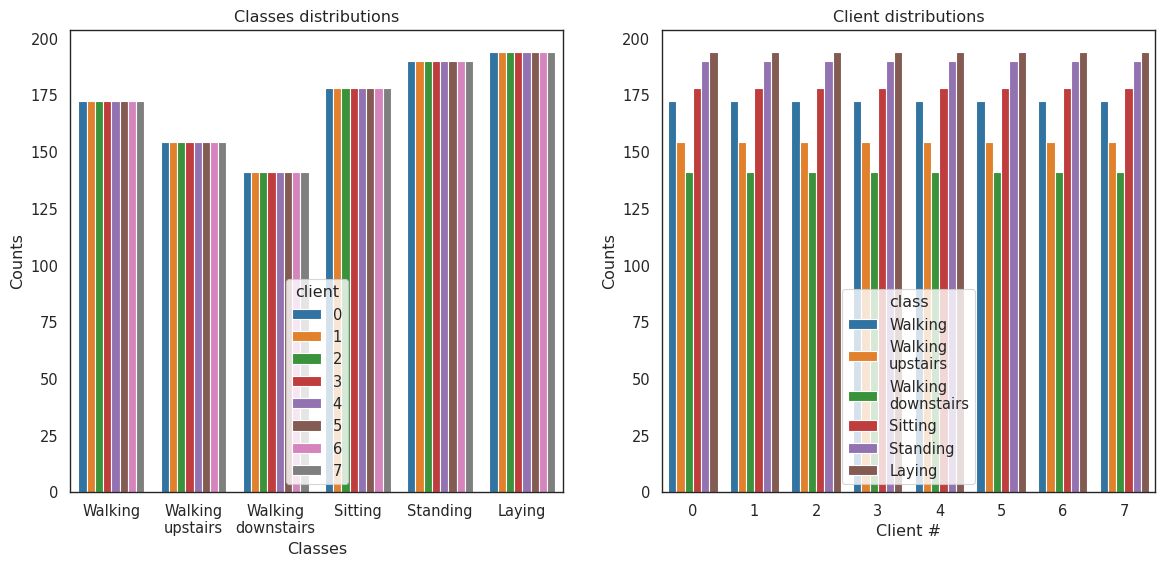

In [31]:
df_bl = plot_classes(trainloaders_bl)

#### Dataloaders for split datasets

In [32]:
# get dataloaders
flip = False
trainloaders, gini_data = \
  generate_dataloaders(X_train_combined, y_train_combined,
                       method_selected, n_splits)

test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

gini_df = pd.DataFrame(gini_data)
print(gini_df)

print("Number of Training Subsets: ", len(trainloaders))


Fold 1 size 1029 class distribution: Counter({5: 933, 3: 22, 4: 22, 0: 19, 1: 18, 2: 15})
Fold 2 size 1029 class distribution: Counter({4: 915, 3: 38, 0: 33, 2: 17, 1: 15, 5: 11})
Fold 3 size 1029 class distribution: Counter({3: 852, 1: 49, 0: 43, 2: 41, 4: 22, 5: 22})
Fold 4 size 1029 class distribution: Counter({0: 826, 2: 61, 1: 55, 4: 36, 5: 29, 3: 22})
Fold 5 size 1029 class distribution: Counter({1: 741, 2: 79, 5: 68, 4: 53, 3: 50, 0: 38})
Fold 6 size 1029 class distribution: Counter({2: 675, 5: 80, 3: 78, 4: 75, 0: 65, 1: 56})
Fold 7 size 1029 class distribution: Counter({5: 215, 4: 199, 0: 179, 3: 177, 1: 144, 2: 115})
Fold 8 size 1029 class distribution: Counter({4: 201, 5: 196, 3: 182, 0: 173, 1: 155, 2: 122})
   Dataset  Train Gini Index
0        1          0.176111
1        2          0.206309
2        3          0.307920
3        4          0.346792
4        5          0.464793
5        6          0.545640
6        7          0.827021
7        8          0.829267
Number of

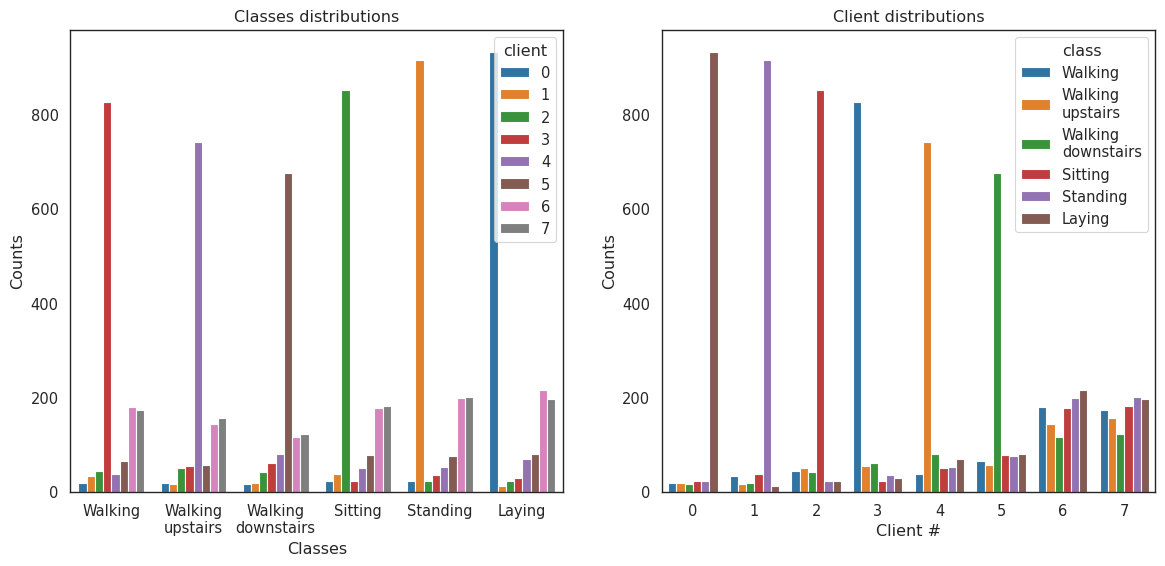

In [33]:
xdf = plot_classes(trainloaders)

##Compute weights

- Index $i$ runs on clients, i.e, 1 to 8 clients
- Index $j$ runs on classes, i.e, 1 to 6 classes
- Properties on $i$ are related to clients: weights $w_i$, Gini coefficient $G_i$, entropy $H_i$
- Properties on $j$ are related to classes: probabilities for picking particular class $j$ for client $i$.

A vector of probabilities $p_i$ is local for a client $i$: $\vec{p}_i=p^i_j\rightarrow \{p^i_1, \dots, p^i_6\}$ with $p^i_j = \frac{\text{count class}\, j\, \text{client}\, i}{N_i}$ with $N_i$ the total number of samples for client $i$. $p^i_j$ is normalized.


The vector $P_j$ is global (common to all clients) $\vec{P}=P_j\rightarrow \{P_1, \dots, P_6\}$ with $P_j = \frac{\text{count class j for all clients}}{N}$ with $N =\sum_i N_i$ the total number of samples for all clients. $P_j$ is normalized.

A set of weights could be constructed by multiplying a vector of a local property times a set of local vectors for each client. For instance, let $\tilde{P}$ be the normalized product of the probabilities of picking a class $j$ in the joint dataset times the square probability for a client $i$ to have this class $j$,
$$\tilde{P}_i = \frac{\sum_j P_j \cdot (p^j_i)^2}{\sum_{i}\sum_{j} P_j \cdot (p^j_i)^2}$$

Setting this squared probabilities adds more importance to majority classes respect to the minority classes.
Then the normalized weights can be computed as the inverse of this value:
$$w_i = \frac{1/\tilde{P_i}}{\sum_i 1/\tilde{P}_i}$$


We can weight by sample size $N_i$ per client $i$ as follows,
$$\alpha_i = \frac{N_i}{N}$$

Finally, the weights are,
$$W_i = \frac{\alpha_i w_i}{\sum_i \alpha_i w_i}$$

In [34]:
# group the dataset by client and class and add the samples
nxdf = xdf.groupby(["client", "class"]).sum()

In [35]:
# build the matrix of number of samples per client per class
S = nxdf.to_numpy().reshape((n_clients, n_classes))

In [36]:
def compute_weights(s):
  """Compute weights given the count of samples per client per class s
  """
  print("Count of samples per class per client\n", s)

  # compute alpha ratio of sample sizes for all clients
  alpha = np.sum(s, axis=1)/np.sum(s)

  # compute pij probabilities for client i to have j class
  p = np.zeros((n_clients, n_classes))
  for i in np.arange(n_clients):
    p[i] = s[i] / np.sum(s[i])
  print("\nProbabilities per client per class\n", p)

  # Compute the probabilities of having class j if we merge all datasets
  S = np.zeros(n_classes)
  P = np.zeros(n_classes)
  for j, ss in enumerate(s.T):
    S[j] = np.sum(ss)
    P[j] = np.sum(ss) / np.sum(s)

  H = [entropy(ss, base=2) for ss in s]
  print("\nTotal samples per class", S)
  print("Total probabilities per class", P)
  print("Entropy", H)
  print("Balance", [h/np.log2(n_classes) for h in H])

  # compute squared probabilities pij*pij
  p2 = p*p
  # compute probabilities by total probabilities P
  iP = np.sum(p2.dot(P))/(p2.dot(P))
  G = [1-np.sum(pp) for pp in p2]
  print("Gini index ", G)
  print("Mixed probabilities inverse", iP)

  # Weights will be the inverse of the result above, normalized
  w = iP / np.sum(iP)
  print("\nPlain weights", w)

  print("\nSample size ratios", alpha)

  # Final weights taking into account sample size
  W = alpha * w / np.sum(alpha * w)
  print("\nFinal weights", W)

  # return weights and probabilities pij
  return W, w, p

In [37]:
W, Uw, p = compute_weights(S)

Count of samples per class per client
 [[933  22  22  19  15  18]
 [ 11  38 915  33  17  15]
 [ 22 852  22  43  41  49]
 [ 29  22  36 826  61  55]
 [ 68  50  53  38  79 741]
 [ 80  78  75  65 675  56]
 [215 177 199 179 115 144]
 [196 182 201 173 122 155]]

Probabilities per client per class
 [[0.90670554 0.02137998 0.02137998 0.01846453 0.01457726 0.01749271]
 [0.01068999 0.03692906 0.88921283 0.03206997 0.01652089 0.01457726]
 [0.02137998 0.82798834 0.02137998 0.04178814 0.03984451 0.04761905]
 [0.0281827  0.02137998 0.03498542 0.80272109 0.05928086 0.05344995]
 [0.06608358 0.04859086 0.05150632 0.03692906 0.07677357 0.72011662]
 [0.07774538 0.07580175 0.0728863  0.06316812 0.65597668 0.05442177]
 [0.20894072 0.17201166 0.19339164 0.1739553  0.11175899 0.13994169]
 [0.19047619 0.17687075 0.19533528 0.16812439 0.11856171 0.15063168]]

Total samples per class [1554. 1421. 1523. 1376. 1125. 1233.]
Total probabilities per class [0.18877551 0.17261905 0.18500972 0.16715258 0.13666181 0.149

In [38]:
def plot_weights(W, p):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
  ax2.set_title('Weights')
  ax1.set_title("Probabilities per client per class $p_{ij}$")
  pd.DataFrame(W).plot.bar(ax=ax2, legend=False)
  sns.heatmap(p.T, ax=ax1, annot=True, fmt=".2f", linewidths=.5)
  ax1.set(xlabel='clients', ylabel='classes')
  ax1.set_yticklabels(class_names.values())
  ax1.set_xlabel("Client #")
  ax2.set(xlabel='clients', ylabel='weights')
  ax2.bar_label(ax2.containers[0], fmt='%.3f')
  ax2.set_xlabel("Client #")
  plt.show()

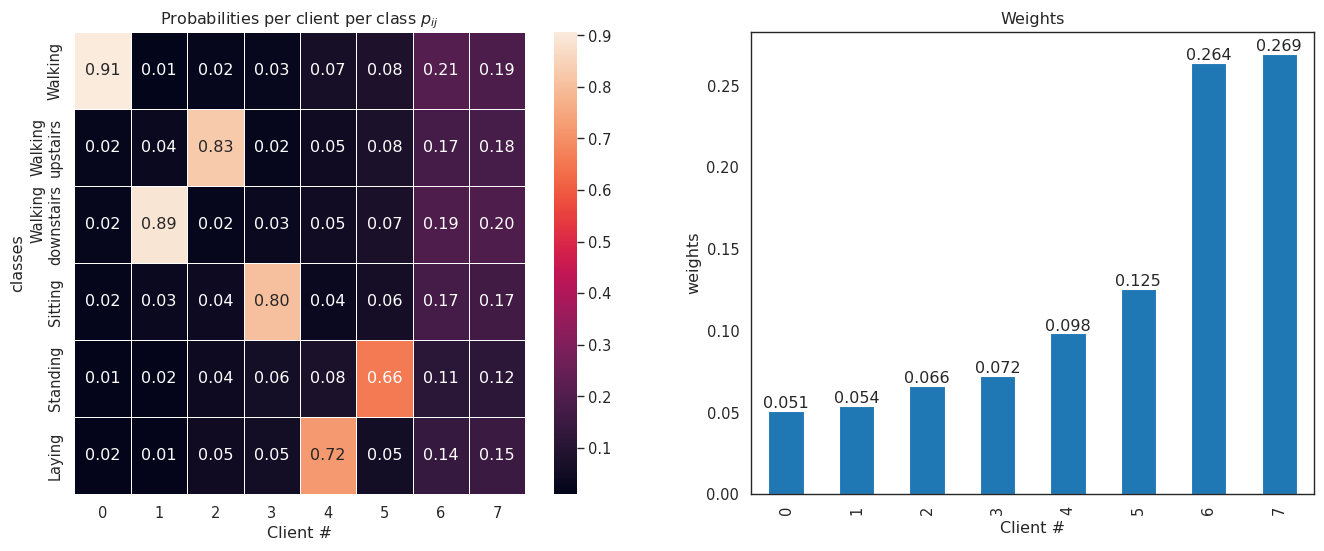

In [39]:
plot_weights(W, p)

#Model

In [40]:
class MLP(nn.Module):
    """ Multi Layer Perceptron """
    def __init__(self) -> None:
        super(MLP, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(561, 437),
            nn.ReLU(),
            nn.Linear(437, 312),
            nn.ReLU(),
            nn.Linear(312, 6)
        )

    def forward(self, x: Tensor) -> Tensor:
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Net = MLP

##Training

###Parameter updates

In [41]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

###Training function

In [42]:
def train(net, trainloader, epochs: int):
    torch.manual_seed(random_seed)
    torch.use_deterministic_algorithms(True)

    training_size = len(trainloader.dataset)
    batch_size = trainloader.batch_size

    # Modify target_epsilon and target_delta here
    noise_generator = torch.Generator()
    noise_generator.manual_seed(random_seed)

    target_delta = 1e-5

    max_grad_norm = 1.0
    noise_multiplier = 1.0  # This value will be used to initialize the PrivacyEngine, but it will be modified automatically to reach the target epsilon

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    model = net
    dataloader = trainloader  # Define dataloader here

    if USE_DP:
        privacy_engine = PrivacyEngine(accountant = 'rdp')

        model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=dataloader,
            target_epsilon=target_epsilon,
            target_delta=target_delta,
            epochs=epochs,
            max_grad_norm=max_grad_norm,
            noise_generator=noise_generator
        )
    else:
        # If not using DP, PrivacyEngine is not defined and can't be used to get epsilon later.
        privacy_engine = None

    model = model.to(DEVICE)

    model.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(dataloader.dataset)

    # After training, you can get the final epsilon
    if privacy_engine:  # Only try to get epsilon if privacy_engine was defined
        final_epsilon = privacy_engine.get_epsilon(delta=target_delta)
        print(f"The target epsilon was: {target_epsilon}")
        print(f"The final epsilon is: {final_epsilon}")


###Model Testing

In [43]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""

    torch.manual_seed(random_seed)
    torch.use_deterministic_algorithms(True)
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()

    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.append(labels.cpu())
            all_predicted.append(predicted.cpu())

    all_labels = torch.cat(all_labels) # concatenate all labels tensors
    all_predicted = torch.cat(all_predicted) # concatenate all predicted tensors

    loss /= len(testloader.dataset)
    accuracy = correct / total

    # Calculate F1 score. Need to convert tensors to numpy arrays
    f1_score_value_micro = f1_score(all_labels.numpy(), all_predicted.numpy(), average='micro')
    f1_score_value_macro = f1_score(all_labels.numpy(), all_predicted.numpy(), average='macro')
    f1_score_value_perclass = f1_score(all_labels.numpy(), all_predicted.numpy(), average=None)

    return accuracy, loss, f1_score_value_micro, f1_score_value_macro, f1_score_value_perclass


#Client implementation

In [44]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):

        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=n_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        accuracy, loss, f1_score_value_micro, f1_score_value_macro, f1_score_value_perclass = test(self.net, self.valloader)
        print(f"[Client {self.cid}] loss: {loss}, accuracy: {accuracy}, f1_score_micro: {f1_score_value_micro}, f1_score_macro: {f1_score_value_macro}, f1_score_perclass: {f1_score_value_perclass}")  # Add this line

        return float(loss), len(self.valloader), {
                                                    "accuracy": float(accuracy),
                                                    "f1_score_micro": float(f1_score_value_micro),
                                                    "f1_score_macro": float(f1_score_value_macro),
                                                    "f1_score_perclass": [float(score) for score in f1_score_value_perclass]}


def client_fn(cid) -> FlowerClient:
    torch.manual_seed(1)
    # torch.use_deterministic_algorithms(True)
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, test_dataloader)

#Aggregation strategies

##Custom aggregation

In [45]:
class WeightedFedAvg(fl.server.strategy.FedAvg):
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        keygen=None,
        initial_parameters: Optional[Parameters] = None,
        weighting_fn = None
    ) -> None:
        """Implement Simple Paillier Averaging strategy.

        Implementation based on flower FedAvg

        Parameters
        ----------
        fraction_fit
            Fraction of clients used during training. Defaults to 0.1.
        fraction_evaluate
            Fraction of clients used during validation. Defaults to 0.1.
        min_fit_clients
            Minimum number of clients used during training. Defaults to 2.
        min_evaluate_clients
            Minimum number of clients used during validation. Defaults to 2.
        min_available_clients
            Minimum number of total clients in the system. Defaults to 2.
        eval_fn
            Optional function used for validation. Defaults to None.
        on_fit_config_fn
            Function used to configure training. Defaults to None.
        on_evaluate_config_fn
            Function used to configure validation. Defaults to None.
        accept_failures
            Whether or not accept rounds containing failures. Defaults to True.
        initial_parameters
            Initial global model parameters.
        weighting_fn
            Custom weighting function for average aggregation of parameters
        """
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.weighting_fn = weighting_fn

    def aggregate_fit(
          self,
          server_round: int,
          results: List[Tuple[ClientProxy, FitRes]],
          failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
        ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results into weights
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        # Extract client ids
        cids = [int(cp.cid) for cp, _ in results]
        print("client proxies", cids)

        # compute weights using the weighting function
        avg_weights = self.weighting_fn(weights_results, cids)

        # Create a list of weights, each multiplied by the weights computed above
        weighted_weights = [
            [layer * avg_weights for layer in weights] for (weights, _), avg_weights in zip(weights_results, avg_weights)
        ]

        # Compute average weights of each layer
        weights_prime: NDArrays = [
            reduce(np.add, layer_updates)
            for layer_updates in zip(*weighted_weights)
        ]
        return ndarrays_to_parameters(weights_prime), {}

def custom_weighting(results, cids):
    """Given results (which have the weights) and client ids compute the vector
    of weights of size n_clients.
    """

    total_samples = sum([num_samples for _, num_samples in results])
    if avg_strategy == "standard":
      # Plain FedAvg as flower (no different as flower implementation)
      weights = [num_samples / total_samples for _, num_samples in results]
    elif avg_strategy == "arithmetic":
      weights = np.ones(n_clients)/len(cids)   # Simple FedAvs, arithmetic average
    elif avg_strategy == "weighted":
      # use custom weights
      alpha = np.array([num_samples / total_samples for _, num_samples in results])
      # reorder Uw that depends on (Pj, pij) and normalize by sample size alpha
      weights = alpha * Uw[cids] / np.sum(alpha * Uw[cids])

    print(f"num samples {[num_samples for _, num_samples in results]}")
    print(f"Aggregation {avg_strategy} weights {weights}")
    print(f"Sum of weights: {np.sum(weights)}")
    print(f"FedAvg weights {[num_samples / total_samples for _, num_samples in results]}")

    return weights

In [46]:
# how to aggregate custom evaluation results https://flower.dev/docs/save-progress.html

Scalar = NewType("Scalar", float)
model_metrics = {}
set_random_seeds(random_seed)

def custom_aggregate_evaluate(
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy , fl.common.EvaluateRes]],
        failures: List[BaseException],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:

    if not results:
        return None, {}

    weights, losses, metrics = zip(*[(r.num_examples, r.loss, r.metrics) for _, r in results])

    total_weight = sum(weights)

    weighted_loss_sum = sum(w * l for w, l in zip(weights, losses))

    loss = weighted_loss_sum / total_weight

    aggregated_metrics = {}
    num_classes = len(results[0][1].metrics.get('f1_score_perclass', []))

    for metric_name in results[0][1].metrics:
        if metric_name != "f1_score_perclass":
            metric_sum = sum(
                r.metrics.get(metric_name, 0) * r.num_examples for _, r in results
            )
            aggregated_metric = metric_sum / total_weight
            aggregated_metrics[metric_name] = aggregated_metric
        else:
            # Calculate weighted F1 scores for each class
            per_class_f1_scores = [r.metrics.get(metric_name, [0]*num_classes) for _, r in results]
            per_class_f1_scores_weighted_sum = [
                sum(w * class_f1_score for w, class_f1_score in zip(weights, class_f1_scores))
                for class_f1_scores in zip(*per_class_f1_scores)
            ]
            aggregated_per_class_f1_scores = [weighted_sum / total_weight for weighted_sum in per_class_f1_scores_weighted_sum]
            aggregated_metrics[metric_name] = aggregated_per_class_f1_scores

    # Return aggregated loss and metrics (i.e., aggregated accuracy and F1 score)
    return loss, aggregated_metrics




In [47]:
model_metricsF1={}

In [48]:
%%time
strategies_acc = []
loop_list = strategy_list

for strategy_type in loop_list:
  print("\nAnalyzing Strategy... : ", strategy_type.capitalize())

  params = get_parameters(MLP())

  if strategy_type == 'fedavg':
    # Creazione della Strategia FedAvg
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1./n_clients,
        min_fit_clients=n_clients,
        min_evaluate_clients=1,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == 'fedadagrad':
    # Creazione della Strategia FedAdagrad
    strategy = fl.server.strategy.FedAdagrad(
        fraction_fit=1.0,
        fraction_evaluate=1./n_clients,
        min_fit_clients=n_clients,
        min_evaluate_clients=1,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == 'fedadam':
    # Creazione della Strategia FedAdam
    strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1./n_clients,
        min_fit_clients=n_clients,
        min_evaluate_clients=1,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == 'fedyogi':
    # Creazione della Strategia FedYogi
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedYogi(
        fraction_fit=1.0,
        fraction_evaluate=1./n_clients,
        min_fit_clients=n_clients,
        min_evaluate_clients=1,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )


  if strategy_type == 'weightedfedavg':
    # Creazione della Strategia personalizzata WeightedFedAvg

    strategy = WeightedFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1./n_clients,
        min_fit_clients=n_clients,
        min_evaluate_clients=1,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
        weighting_fn=custom_weighting
  )
  strategy.aggregate_evaluate = custom_aggregate_evaluate

  # Specifica le risorse del client se si ha bisogno della GPU (default a 1 per CPU e 0 per GPU)
  client_resources = None
  if DEVICE.type == "cuda":
      client_resources = {"num_gpus": 1}

  # Avvio della Simulazione
  history = fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=n_clients,
      config=fl.server.ServerConfig(num_rounds=n_rounds),
      strategy=strategy,
      client_resources=client_resources,
  )

  aggregated_metrics = history.metrics_distributed

  loss_dist = history.losses_distributed
  acc = [m[1] for m in history.metrics_distributed['accuracy']]
  f1_scores_micro = [m[1] for m in history.metrics_distributed['f1_score_micro']]
  f1_scores_macro = [m[1] for m in history.metrics_distributed['f1_score_macro']]
  f1_scores_perclass = [m[1] for m in history.metrics_distributed['f1_score_perclass']]
  rounds = [m[0] for m in history.metrics_distributed['accuracy']]

  model_metrics[strategy_type] = {'accuracy': acc, 'f1_score_micro': f1_scores_micro, 'f1_score_macro': f1_scores_macro, 'f1_score_perclass': f1_scores_perclass}
  model_metricsF1[strategy_type] = {'f1_score': f1_scores_macro}
  '''
  # Plot the accuracy and F1 scores
  plt.figure()
  #plt.plot(rounds, acc, label=strategy_type.capitalize()+' Accuracy', color = strategy_colors[loop_list.index(strategy_type)])
  #plt.plot(rounds, f1_scores_micro, label=strategy_type.capitalize()+' F1 Score Micro', color = strategy_colors[(loop_list.index(strategy_type) + 1) % len(strategy_colors)])
  plt.plot(rounds, f1_scores_macro, label=strategy_type.capitalize()+' F1 Score Macro', color = strategy_colors[(loop_list.index(strategy_type) + 2) % len(strategy_colors)])
  #plt.plot(rounds, model_metricsF1[strategy_type], label=strategy_type.capitalize()+' F1 Score', color = strategy_colors[(loop_list.index(strategy_type) + 2) % len(strategy_colors)])

  plt.legend()
  plt.title(method_selected.capitalize() + " - F1 Scores")
  #plt.title(strategy_type.capitalize() + " Accuracy and F1 Scores")
  plt.xlabel("Round")  # Added x-label
  plt.ylabel("Score")  # Added y-label
  #plt.savefig(f"{save_path}/"+strategy_type+"_acc_f1.png", dpi = 300)
  plt.savefig(f"{save_path}/"+strategy_type+"prova_f1.png", dpi = 300)
  plt.show()
  plt.close()

  # Walking, Walking_upstairs, Walking_downstairs, Sitting, Standing, Laying
  #class_names = {0: "Walking", 1: "Walking_upstairs", 2: "Walking_downstairs", 3: "Sitting", 4: "Standing", 5: "Laying"}


  # Plot each class' F1 score in a new figure
  plt.figure()

  # Plot each class' F1 score in a new figure
  plt.figure()
  for i, class_f1_scores in enumerate(zip(*f1_scores_perclass)):
      plt.plot(rounds, class_f1_scores, label=f' {class_names[i]}', color = strategy_colors[(loop_list.index(strategy_type) + 3 + i) % len(strategy_colors)])

  plt.legend()
  plt.title(strategy_type.capitalize() + " Per Class F1 Scores")
  plt.xlabel("Round")  # Added x-label
  plt.ylabel("Score")  # Added y-label
  plt.savefig(f"{save_path}/"+strategy_type+"_perclass_f1.png", dpi = 300)
  plt.show()
  plt.close()

  strategies_acc.append((strategy_type, max(acc), acc[-1], max(f1_scores_micro), f1_scores_micro[-1], max(f1_scores_macro), f1_scores_macro[-1]))
 '''


INFO flwr 2023-10-11 13:17:14,065 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)



Analyzing Strategy... :  Fedavg


2023-10-11 13:17:20,715	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-11 13:17:25,147 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7857731175.0, 'CPU': 2.0, 'object_store_memory': 3928865587.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7857731175.0, 'CPU': 2.0, 'object_store_memory': 3928865587.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-10-11 13:17:25,152 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-11 13:17:25,155 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-10-11 13:17:25,229 | app.py:270 | Flower VCE: Creating Virt

(DefaultActor pid=2222) [Client 7] fit, config: {}


DEBUG flwr 2023-10-11 13:17:45,802 | server.py:236 | fit_round 1 received 8 results and 0 failures
DEBUG:flwr:fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-10-11 13:17:45,835 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-10-11 13:17:45,839 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:17:46,035 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:17:46,039 | server.py:222 | fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 2: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 7] evaluate, config: {}
(DefaultActor pid=2221) [Client 7] loss: 0.03487726073820614, accuracy: 0.5616504854368932, f1_score_micro: 0.5616504854368932, f1_score_macro: 0.528370340285708, f1_score_perclass: [0.73578595 0.51781473 0.65176471 0.29864253 0.28070175 0.68551237]
(DefaultActor pid=2222) [Client 3] fit, config: {} [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


DEBUG flwr 2023-10-11 13:17:48,869 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:17:48,898 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:17:49,103 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:17:49,109 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2222) [Client 4] evaluate, config: {}
(DefaultActor pid=2222) [Client 4] loss: 0.013442072171030692, accuracy: 0.866504854368932, f1_score_micro: 0.866504854368932, f1_score_macro: 0.859679999959499, f1_score_perclass: [0.94083694 0.82846715 0.87261146 0.70546737 0.83240844 0.97828863]


DEBUG flwr 2023-10-11 13:17:53,493 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:17:53,541 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:17:53,830 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:17:53,836 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2222) [Client 5] evaluate, config: {}
(DefaultActor pid=2221) [Client 5] fit, config: {} [repeated 8x across cluster]
(DefaultActor pid=2222) [Client 5] loss: 0.00817992711096134, accuracy: 0.9014563106796116, f1_score_micro: 0.9014563106796116, f1_score_macro: 0.9001137031134756, f1_score_perclass: [0.96709585 0.94533762 0.93772894 0.73162393 0.8354143  0.98348158]


DEBUG flwr 2023-10-11 13:17:57,730 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:17:57,757 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:17:57,918 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:17:57,921 | server.py:222 | fit_round 5: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 5: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2222) [Client 6] evaluate, config: {}
(DefaultActor pid=2222) [Client 6] loss: 0.006964508208979681, accuracy: 0.9087378640776699, f1_score_micro: 0.9087378640776699, f1_score_macro: 0.9078249910536647, f1_score_perclass: [0.97841727 0.95707472 0.95027624 0.7357513  0.83689539 0.98853503]
(DefaultActor pid=2222) [Client 2] fit, config: {} [repeated 11x across cluster]


DEBUG flwr 2023-10-11 13:18:00,758 | server.py:236 | fit_round 5 received 8 results and 0 failures
DEBUG:flwr:fit_round 5 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:00,786 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:00,960 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:00,965 | server.py:222 | fit_round 6: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 6: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 2] evaluate, config: {}
(DefaultActor pid=2221) [Client 2] loss: 0.005804112535512563, accuracy: 0.925242718446602, f1_score_micro: 0.925242718446602, f1_score_macro: 0.9259913060018518, f1_score_perclass: [0.98129496 0.96774194 0.96376812 0.79483037 0.85849057 0.98982188]


DEBUG flwr 2023-10-11 13:18:03,814 | server.py:236 | fit_round 6 received 8 results and 0 failures
DEBUG:flwr:fit_round 6 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:03,843 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:04,025 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:04,028 | server.py:222 | fit_round 7: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 7: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2222) [Client 2] fit, config: {} [repeated 13x across cluster]
(DefaultActor pid=2222) [Client 0] evaluate, config: {}
(DefaultActor pid=2222) [Client 0] loss: 0.0052683384636941465, accuracy: 0.9320388349514563, f1_score_micro: 0.9320388349514563, f1_score_macro: 0.9329045097617662, f1_score_perclass: [0.98129496 0.96940419 0.96551724 0.81847134 0.87039239 0.99234694]


DEBUG flwr 2023-10-11 13:18:06,957 | server.py:236 | fit_round 7 received 8 results and 0 failures
DEBUG:flwr:fit_round 7 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:07,000 | server.py:173 | evaluate_round 7: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 7: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:07,279 | server.py:187 | evaluate_round 7 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:07,282 | server.py:222 | fit_round 8: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 8: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 1] evaluate, config: {}
(DefaultActor pid=2221) [Client 1] loss: 0.005127652012969105, accuracy: 0.9296116504854369, f1_score_micro: 0.9296116504854369, f1_score_macro: 0.9306336671067897, f1_score_perclass: [0.9869754  0.97271268 0.97287523 0.79537954 0.85714286 0.9987163 ]
(DefaultActor pid=2221) [Client 6] fit, config: {} [repeated 13x across cluster]


DEBUG flwr 2023-10-11 13:18:12,401 | server.py:236 | fit_round 8 received 8 results and 0 failures
DEBUG:flwr:fit_round 8 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:12,440 | server.py:173 | evaluate_round 8: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 8: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:12,668 | server.py:187 | evaluate_round 8 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:12,674 | server.py:222 | fit_round 9: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 9: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 1] evaluate, config: {}
(DefaultActor pid=2221) [Client 1] loss: 0.0045506642534605506, accuracy: 0.9398058252427185, f1_score_micro: 0.9398058252427185, f1_score_macro: 0.9411461613463791, f1_score_perclass: [0.9869754  0.97419355 0.97482014 0.83544304 0.87544484 1.        ]
(DefaultActor pid=2221) [Client 4] fit, config: {} [repeated 11x across cluster]


DEBUG flwr 2023-10-11 13:18:15,813 | server.py:236 | fit_round 9 received 8 results and 0 failures
DEBUG:flwr:fit_round 9 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:15,841 | server.py:173 | evaluate_round 9: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 9: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:16,041 | server.py:187 | evaluate_round 9 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:16,048 | server.py:222 | fit_round 10: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 10: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 5] evaluate, config: {}
(DefaultActor pid=2221) [Client 5] loss: 0.004512180500094173, accuracy: 0.9378640776699029, f1_score_micro: 0.9378640776699029, f1_score_macro: 0.93917826817699, f1_score_perclass: [0.98701299 0.97584541 0.97287523 0.82802548 0.87131051 1.        ]


DEBUG flwr 2023-10-11 13:18:18,980 | server.py:236 | fit_round 10 received 8 results and 0 failures
DEBUG:flwr:fit_round 10 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:19,014 | server.py:173 | evaluate_round 10: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 10: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:19,227 | server.py:187 | evaluate_round 10 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:19,229 | server.py:222 | fit_round 11: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 11: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2222) [Client 3] loss: 0.004096579770512372, accuracy: 0.95, f1_score_micro: 0.9500000000000001, f1_score_macro: 0.9515119847321568, f1_score_perclass: [0.98701299 0.97893031 0.97666068 0.87369985 0.89276808 1.        ]
(DefaultActor pid=2221) [Client 2] fit, config: {} [repeated 13x across cluster]
(DefaultActor pid=2222) [Client 3] evaluate, config: {}


DEBUG flwr 2023-10-11 13:18:22,144 | server.py:236 | fit_round 11 received 8 results and 0 failures
DEBUG:flwr:fit_round 11 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:22,175 | server.py:173 | evaluate_round 11: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 11: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:22,335 | server.py:187 | evaluate_round 11 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:22,337 | server.py:222 | fit_round 12: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 12: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 4] evaluate, config: {}
(DefaultActor pid=2221) [Client 4] loss: 0.004247378023540221, accuracy: 0.945631067961165, f1_score_micro: 0.945631067961165, f1_score_macro: 0.9469077436753158, f1_score_perclass: [0.99130435 0.97615262 0.97445255 0.85358255 0.88595438 1.        ]


DEBUG flwr 2023-10-11 13:18:26,781 | server.py:236 | fit_round 12 received 8 results and 0 failures
DEBUG:flwr:fit_round 12 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:26,824 | server.py:173 | evaluate_round 12: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 12: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:27,100 | server.py:187 | evaluate_round 12 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:27,104 | server.py:222 | fit_round 13: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 13: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 6] evaluate, config: {}
(DefaultActor pid=2221) [Client 5] fit, config: {} [repeated 11x across cluster]
(DefaultActor pid=2221) [Client 6] loss: 0.003931073985487512, accuracy: 0.9495145631067962, f1_score_micro: 0.9495145631067962, f1_score_macro: 0.9509555975359305, f1_score_perclass: [0.99130435 0.9823435  0.97833935 0.86244204 0.89130435 1.        ]


DEBUG flwr 2023-10-11 13:18:31,415 | server.py:236 | fit_round 13 received 8 results and 0 failures
DEBUG:flwr:fit_round 13 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:31,447 | server.py:173 | evaluate_round 13: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 13: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:31,626 | server.py:187 | evaluate_round 13 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:31,631 | server.py:222 | fit_round 14: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 14: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2222) [Client 7] evaluate, config: {}
(DefaultActor pid=2222) [Client 3] fit, config: {} [repeated 11x across cluster]
(DefaultActor pid=2222) [Client 7] loss: 0.0034653026303186, accuracy: 0.9553398058252427, f1_score_micro: 0.9553398058252427, f1_score_macro: 0.9567639700956766, f1_score_perclass: [0.99130435 0.98076923 0.97649186 0.89111748 0.9009009  1.        ]


DEBUG flwr 2023-10-11 13:18:34,538 | server.py:236 | fit_round 14 received 8 results and 0 failures
DEBUG:flwr:fit_round 14 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:34,568 | server.py:173 | evaluate_round 14: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 14: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:34,764 | server.py:187 | evaluate_round 14 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:18:34,768 | server.py:222 | fit_round 15: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 15: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2221) [Client 5] loss: 0.0038835195752168167, accuracy: 0.9451456310679611, f1_score_micro: 0.9451456310679611, f1_score_macro: 0.9466934280185572, f1_score_perclass: [0.99127907 0.98064516 0.980322   0.84591195 0.88200238 1.        ]
(DefaultActor pid=2221) [Client 5] evaluate, config: {}


DEBUG flwr 2023-10-11 13:18:37,793 | server.py:236 | fit_round 15 received 8 results and 0 failures
DEBUG:flwr:fit_round 15 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:18:37,824 | server.py:173 | evaluate_round 15: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 15: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:18:38,027 | server.py:187 | evaluate_round 15 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 1 results and 0 failures
INFO flwr 2023-10-11 13:18:38,030 | server.py:153 | FL finished in 72.78107960200003
INFO:flwr:FL finished in 72.78107960200003
INFO flwr 2023-10-11 13:18:38,039 | app.py:225 | app_fit: losses_distributed [(1, 0.03487726073820614), (2, 0.013442072171030692), (3, 0.00817992711096134), (4, 0.006964508208979681), (5, 0.005804112535512563), (6, 0.0052683384636941465), (7, 0.005127652012969105), (8, 0.0045506642534605506), (9, 0.004512180500094173), (10, 0.004096579770512372), (11, 0.004247378023

(DefaultActor pid=2222) [Client 4] evaluate, config: {}
(DefaultActor pid=2222) [Client 0] fit, config: {} [repeated 13x across cluster]

Analyzing Strategy... :  Weightedfedavg


(pid=2221) 2023-10-11 13:17:35.904222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-11 13:18:43,375	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-11 13:18:46,776 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3923983564.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7847967131.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3923983564.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7847967131.0}
INFO flwr 2023-10-11 13:18:46,785 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-11 13:18:46,789 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resourc

(DefaultActor pid=2880) [Client 2] fit, config: {}


DEBUG flwr 2023-10-11 13:19:04,972 | server.py:236 | fit_round 1 received 8 results and 0 failures
DEBUG:flwr:fit_round 1 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:05,002 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 8)


client proxies [1, 5, 0, 3, 4, 6, 7, 2]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.05384331 0.12538581 0.05082881 0.07246163 0.09826669 0.26374194
 0.26925751 0.0662143 ]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 7] evaluate, config: {}


DEBUG flwr 2023-10-11 13:19:05,223 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:05,227 | server.py:222 | fit_round 2: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 2: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2882) [Client 7] loss: 0.02556978805551251, accuracy: 0.6854368932038835, f1_score_micro: 0.6854368932038835, f1_score_macro: 0.6593802497093015, f1_score_perclass: [0.74047187 0.6693712  0.66504854 0.64257028 0.27252747 0.96629213]
(DefaultActor pid=2880) [Client 2] fit, config: {} [repeated 11x across cluster]


DEBUG flwr 2023-10-11 13:19:08,068 | server.py:236 | fit_round 2 received 8 results and 0 failures
DEBUG:flwr:fit_round 2 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:08,102 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 8)


client proxies [4, 0, 2, 5, 3, 1, 6, 7]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.09826669 0.05082881 0.0662143  0.12538581 0.07246163 0.05384331
 0.26374194 0.26925751]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


DEBUG flwr 2023-10-11 13:19:08,316 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:08,319 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2880) [Client 3] evaluate, config: {}
(DefaultActor pid=2880) [Client 3] loss: 0.00886330087352725, accuracy: 0.8970873786407767, f1_score_micro: 0.8970873786407767, f1_score_macro: 0.8965384936224013, f1_score_perclass: [0.97496318 0.9324547  0.92783505 0.73267327 0.8358209  0.97548387]


DEBUG flwr 2023-10-11 13:19:11,068 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:11,108 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 8)


client proxies [3, 0, 6, 5, 2, 4, 1, 7]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.07246163 0.05082881 0.26374194 0.12538581 0.0662143  0.09826669
 0.05384331 0.26925751]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 6] evaluate, config: {}
(DefaultActor pid=2880) [Client 5] fit, config: {} [repeated 12x across cluster]


DEBUG flwr 2023-10-11 13:19:11,302 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:11,304 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2882) [Client 6] loss: 0.006123824428441455, accuracy: 0.925242718446602, f1_score_micro: 0.925242718446602, f1_score_macro: 0.9271041842963689, f1_score_perclass: [0.98689956 0.96343402 0.96188748 0.8095952  0.8574969  0.98331194]


DEBUG flwr 2023-10-11 13:19:14,689 | server.py:236 | fit_round 4 received 8 results and 0 failures
DEBUG:flwr:fit_round 4 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:14,746 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 8)


client proxies [1, 0, 3, 2, 7, 5, 4, 6]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.05384331 0.05082881 0.07246163 0.0662143  0.26925751 0.12538581
 0.09826669 0.26374194]
Sum of weights: 0.9999999999999999
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


DEBUG flwr 2023-10-11 13:19:15,048 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:15,051 | server.py:222 | fit_round 5: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 5: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2880) [Client 6] evaluate, config: {}
(DefaultActor pid=2882) [Client 3] fit, config: {} [repeated 11x across cluster]
(DefaultActor pid=2880) [Client 6] loss: 0.005448294982531117, accuracy: 0.9296116504854369, f1_score_micro: 0.9296116504854369, f1_score_macro: 0.9310835243923616, f1_score_perclass: [0.98984035 0.97115385 0.97111913 0.80254777 0.86084906 0.99099099]


DEBUG flwr 2023-10-11 13:19:19,952 | server.py:236 | fit_round 5 received 8 results and 0 failures
DEBUG:flwr:fit_round 5 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:19,997 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 8)


client proxies [1, 0, 7, 2, 3, 5, 6, 4]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.05384331 0.05082881 0.26925751 0.0662143  0.07246163 0.12538581
 0.26374194 0.09826669]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


DEBUG flwr 2023-10-11 13:19:20,283 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:20,285 | server.py:222 | fit_round 6: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 6: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2880) [Client 7] evaluate, config: {}
(DefaultActor pid=2880) [Client 7] loss: 0.004867631558654378, accuracy: 0.9359223300970874, f1_score_micro: 0.9359223300970873, f1_score_macro: 0.9373050945316215, f1_score_perclass: [0.98417266 0.9726248  0.96914701 0.8299532  0.8705036  0.99742931]
(DefaultActor pid=2880) [Client 2] fit, config: {} [repeated 10x across cluster]


DEBUG flwr 2023-10-11 13:19:23,141 | server.py:236 | fit_round 6 received 8 results and 0 failures
DEBUG:flwr:fit_round 6 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:23,177 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:19:23,343 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:23,346 | server.py:222 | fit_round 7: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 7: strategy sampled 8 clients (out of 8)


client proxies [6, 2, 3, 5, 1, 4, 7, 0]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.26374194 0.0662143  0.07246163 0.12538581 0.05384331 0.09826669
 0.26925751 0.05082881]
Sum of weights: 0.9999999999999998
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 5] loss: 0.004322355042564348, accuracy: 0.9388349514563107, f1_score_micro: 0.9388349514563107, f1_score_macro: 0.94027534973094, f1_score_perclass: [0.99418605 0.97749196 0.97307002 0.82834646 0.87112172 0.9974359 ]
(DefaultActor pid=2882) [Client 5] evaluate, config: {}


DEBUG flwr 2023-10-11 13:19:26,248 | server.py:236 | fit_round 7 received 8 results and 0 failures
DEBUG:flwr:fit_round 7 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:26,282 | server.py:173 | evaluate_round 7: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 7: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:19:26,438 | server.py:187 | evaluate_round 7 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:26,449 | server.py:222 | fit_round 8: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 8: strategy sampled 8 clients (out of 8)


client proxies [1, 2, 0, 7, 3, 4, 5, 6]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.05384331 0.0662143  0.05082881 0.26925751 0.07246163 0.09826669
 0.12538581 0.26374194]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2880) [Client 7] evaluate, config: {}
(DefaultActor pid=2882) [Client 1] fit, config: {} [repeated 14x across cluster]
(DefaultActor pid=2880) [Client 7] loss: 0.004063913991982208, accuracy: 0.9446601941747573, f1_score_micro: 0.9446601941747573, f1_score_macro: 0.9462884900819638, f1_score_perclass: [0.99272198 0.9807074  0.97849462 0.84651163 0.88057901 0.9987163 ]


DEBUG flwr 2023-10-11 13:19:29,403 | server.py:236 | fit_round 8 received 8 results and 0 failures
DEBUG:flwr:fit_round 8 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:29,438 | server.py:173 | evaluate_round 8: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 8: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:19:29,595 | server.py:187 | evaluate_round 8 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:29,599 | server.py:222 | fit_round 9: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 9: strategy sampled 8 clients (out of 8)


client proxies [2, 6, 3, 0, 5, 4, 1, 7]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.0662143  0.26374194 0.07246163 0.05082881 0.12538581 0.09826669
 0.05384331 0.26925751]
Sum of weights: 0.9999999999999999
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 7] loss: 0.004210870336849712, accuracy: 0.9373786407766991, f1_score_micro: 0.9373786407766991, f1_score_macro: 0.938875488648658, f1_score_perclass: [0.99125364 0.9775641  0.97482014 0.8224     0.86721504 1.        ]
(DefaultActor pid=2882) [Client 7] evaluate, config: {}
(DefaultActor pid=2882) [Client 1] fit, config: {} [repeated 12x across cluster]


DEBUG flwr 2023-10-11 13:19:34,823 | server.py:236 | fit_round 9 received 8 results and 0 failures
DEBUG:flwr:fit_round 9 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:34,887 | server.py:173 | evaluate_round 9: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 9: strategy sampled 1 clients (out of 8)


client proxies [3, 2, 6, 7, 0, 5, 1, 4]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.07246163 0.0662143  0.26374194 0.26925751 0.05082881 0.12538581
 0.05384331 0.09826669]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


DEBUG flwr 2023-10-11 13:19:35,191 | server.py:187 | evaluate_round 9 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:35,194 | server.py:222 | fit_round 10: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 10: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2882) [Client 1] evaluate, config: {}
(DefaultActor pid=2882) [Client 1] loss: 0.0035201140507621674, accuracy: 0.958252427184466, f1_score_micro: 0.958252427184466, f1_score_macro: 0.9598019239269292, f1_score_perclass: [0.99272198 0.98555377 0.98384201 0.89117647 0.90680101 0.9987163 ]
(DefaultActor pid=2880) [Client 5] fit, config: {} [repeated 7x across cluster]


DEBUG flwr 2023-10-11 13:19:41,091 | server.py:236 | fit_round 10 received 8 results and 0 failures
DEBUG:flwr:fit_round 10 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:41,146 | server.py:173 | evaluate_round 10: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 10: strategy sampled 1 clients (out of 8)


client proxies [4, 1, 2, 7, 6, 0, 5, 3]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.09826669 0.05384331 0.0662143  0.26925751 0.26374194 0.05082881
 0.12538581 0.07246163]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 7] evaluate, config: {}


DEBUG flwr 2023-10-11 13:19:41,475 | server.py:187 | evaluate_round 10 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:41,478 | server.py:222 | fit_round 11: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 11: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2882) [Client 7] loss: 0.0035316458184416724, accuracy: 0.9524271844660194, f1_score_micro: 0.9524271844660194, f1_score_macro: 0.9542779628196323, f1_score_perclass: [0.99272198 0.98717949 0.98378378 0.87009063 0.89189189 1.        ]
(DefaultActor pid=2882) [Client 6] fit, config: {} [repeated 7x across cluster]


DEBUG flwr 2023-10-11 13:19:44,888 | server.py:236 | fit_round 11 received 8 results and 0 failures
DEBUG:flwr:fit_round 11 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:44,920 | server.py:173 | evaluate_round 11: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 11: strategy sampled 1 clients (out of 8)
DEBUG flwr 2023-10-11 13:19:45,069 | server.py:187 | evaluate_round 11 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:45,075 | server.py:222 | fit_round 12: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 12: strategy sampled 8 clients (out of 8)


client proxies [4, 5, 6, 1, 0, 2, 3, 7]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.09826669 0.12538581 0.26374194 0.05384331 0.05082881 0.0662143
 0.07246163 0.26925751]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 7] evaluate, config: {}
(DefaultActor pid=2882) [Client 7] loss: 0.0033857415701506787, accuracy: 0.9538834951456311, f1_score_micro: 0.9538834951456311, f1_score_macro: 0.9553508509577716, f1_score_perclass: [0.99274311 0.98402556 0.97826087 0.87856072 0.89851485 1.        ]


DEBUG flwr 2023-10-11 13:19:47,911 | server.py:236 | fit_round 12 received 8 results and 0 failures
DEBUG:flwr:fit_round 12 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:47,957 | server.py:173 | evaluate_round 12: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 12: strategy sampled 1 clients (out of 8)


client proxies [6, 2, 7, 4, 0, 5, 3, 1]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.26374194 0.0662143  0.26925751 0.09826669 0.05082881 0.12538581
 0.07246163 0.05384331]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


DEBUG flwr 2023-10-11 13:19:48,179 | server.py:187 | evaluate_round 12 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:48,185 | server.py:222 | fit_round 13: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 13: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2880) [Client 3] loss: 0.0032727339264294764, accuracy: 0.9572815533980582, f1_score_micro: 0.9572815533980582, f1_score_macro: 0.9590914849478641, f1_score_perclass: [0.99418605 0.99029126 0.98752228 0.88155922 0.9009901  1.        ]
(DefaultActor pid=2880) [Client 3] fit, config: {} [repeated 14x across cluster]
(DefaultActor pid=2880) [Client 3] evaluate, config: {}


DEBUG flwr 2023-10-11 13:19:51,132 | server.py:236 | fit_round 13 received 8 results and 0 failures
DEBUG:flwr:fit_round 13 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:51,163 | server.py:173 | evaluate_round 13: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 13: strategy sampled 1 clients (out of 8)


client proxies [0, 3, 1, 7, 4, 6, 5, 2]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.05082881 0.07246163 0.05384331 0.26925751 0.09826669 0.26374194
 0.12538581 0.0662143 ]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 6] evaluate, config: {}


DEBUG flwr 2023-10-11 13:19:51,358 | server.py:187 | evaluate_round 13 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:51,361 | server.py:222 | fit_round 14: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 14: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2882) [Client 6] loss: 0.0030145403883844904, accuracy: 0.9606796116504854, f1_score_micro: 0.9606796116504854, f1_score_macro: 0.9623800022474954, f1_score_perclass: [0.99418605 0.99032258 0.98747764 0.89411765 0.9081761  1.        ]
(DefaultActor pid=2880) [Client 2] fit, config: {} [repeated 12x across cluster]


DEBUG flwr 2023-10-11 13:19:55,451 | server.py:236 | fit_round 14 received 8 results and 0 failures
DEBUG:flwr:fit_round 14 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:19:55,501 | server.py:173 | evaluate_round 14: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 14: strategy sampled 1 clients (out of 8)


client proxies [2, 5, 3, 0, 6, 1, 4, 7]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.0662143  0.12538581 0.07246163 0.05082881 0.26374194 0.05384331
 0.09826669 0.26925751]
Sum of weights: 1.0
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2882) [Client 3] evaluate, config: {}


DEBUG flwr 2023-10-11 13:19:55,777 | server.py:187 | evaluate_round 14 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 1 results and 0 failures
DEBUG flwr 2023-10-11 13:19:55,781 | server.py:222 | fit_round 15: strategy sampled 8 clients (out of 8)
DEBUG:flwr:fit_round 15: strategy sampled 8 clients (out of 8)


(DefaultActor pid=2882) [Client 3] loss: 0.0031572867510388197, accuracy: 0.9577669902912621, f1_score_micro: 0.9577669902912621, f1_score_macro: 0.9590346523141333, f1_score_perclass: [0.99127907 0.98245614 0.97826087 0.89380531 0.90840652 1.        ]
(DefaultActor pid=2882) [Client 2] fit, config: {} [repeated 8x across cluster]


DEBUG flwr 2023-10-11 13:20:00,541 | server.py:236 | fit_round 15 received 8 results and 0 failures
DEBUG:flwr:fit_round 15 received 8 results and 0 failures
DEBUG flwr 2023-10-11 13:20:00,573 | server.py:173 | evaluate_round 15: strategy sampled 1 clients (out of 8)
DEBUG:flwr:evaluate_round 15: strategy sampled 1 clients (out of 8)


client proxies [6, 0, 3, 2, 5, 4, 1, 7]
num samples [33, 33, 33, 33, 33, 33, 33, 33]
Aggregation weighted weights [0.26374194 0.05082881 0.07246163 0.0662143  0.12538581 0.09826669
 0.05384331 0.26925751]
Sum of weights: 0.9999999999999999
FedAvg weights [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
(DefaultActor pid=2880) [Client 0] evaluate, config: {}


DEBUG flwr 2023-10-11 13:20:00,789 | server.py:187 | evaluate_round 15 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 1 results and 0 failures
INFO flwr 2023-10-11 13:20:00,795 | server.py:153 | FL finished in 73.944757955
INFO:flwr:FL finished in 73.944757955
INFO flwr 2023-10-11 13:20:00,809 | app.py:225 | app_fit: losses_distributed [(1, 0.02556978805551251), (2, 0.00886330087352725), (3, 0.006123824428441455), (4, 0.005448294982531117), (5, 0.004867631558654378), (6, 0.004322355042564348), (7, 0.004063913991982208), (8, 0.004210870336849712), (9, 0.0035201140507621674), (10, 0.0035316458184416724), (11, 0.0033857415701506787), (12, 0.0032727339264294764), (13, 0.0030145403883844904), (14, 0.0031572867510388197), (15, 0.0029951932555227316)]
INFO:flwr:app_fit: losses_distributed [(1, 0.02556978805551251), (2, 0.00886330087352725), (3, 0.006123824428441455), (4, 0.005448294982531117), (5, 0.004867631558654378), (6, 0.004322355042564348), (7, 0.004063913991982

CPU times: user 18.2 s, sys: 6.25 s, total: 24.5 s
Wall time: 2min 46s


(DefaultActor pid=2880) [Client 0] loss: 0.0029951932555227316, accuracy: 0.9606796116504854, f1_score_micro: 0.9606796116504854, f1_score_macro: 0.9626493467564962, f1_score_perclass: [0.9985444  0.99186992 0.9929078  0.88757396 0.905      1.        ]


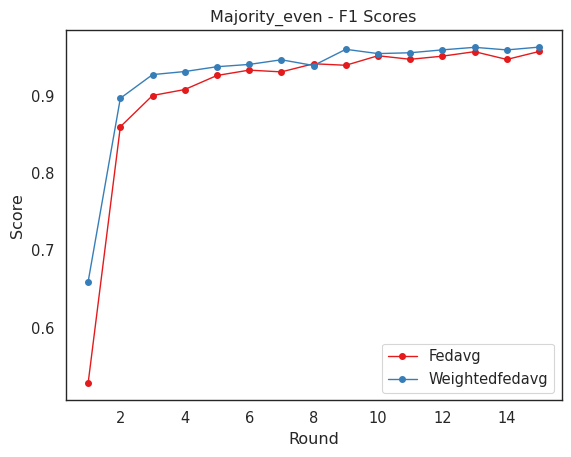

In [49]:
import matplotlib as mpl
cmap = mpl.color_sequences['Set3']


# Plot F1 scores per method
plt.figure()
#plt.plot(rounds, acc, label=strategy_type.capitalize()+' Accuracy', color = strategy_colors[loop_list.index(strategy_type)])
#plt.plot(rounds, f1_scores_micro, label=strategy_type.capitalize()+' F1 Score Micro', color = strategy_colors[(loop_list.index(strategy_type) + 1) % len(strategy_colors)])
#plt.plot(rounds, f1_scores_macro, label=strategy_type.capitalize()+' F1 Score Macro', color = strategy_colors[(loop_list.index(strategy_type) + 2) % len(strategy_colors)])
i=0
for strategy_type in loop_list:
  #plt.plot(rounds, model_metricsF1[strategy_type]['f1_score'] , label=strategy_type.capitalize(), marker='o', markersize=4, linestyle='-', linewidth=1, color = strategy_colors[(loop_list.index(strategy_type) + 2) % len(strategy_colors)])
  plt.plot(rounds, model_metricsF1[strategy_type]['f1_score'] , label=strategy_type.capitalize(), marker='o', markersize=4, linestyle='-', linewidth=1, color = cmap[i])
  i=i+1
plt.legend()
plt.title(method_selected.capitalize() + " - F1 Scores")

#plt.title(strategy_type.capitalize() + " Accuracy and F1 Scores")
plt.xlabel("Round")  # Added x-label
plt.ylabel("Score")  # Added y-label
#plt.savefig(f"{save_path}/"+strategy_type+"_acc_f1.png", dpi = 300)

plt.savefig(f"{save_path}/"+method_selected+"_f1.png", dpi = 300)
plt.show()
plt.close()


In [50]:
cmap = mpl.color_sequences['Set3']
print(cmap[0])

(0.8941176470588236, 0.10196078431372549, 0.10980392156862745)


In [51]:
print(model_metrics[strategy_type])

{'accuracy': [0.6854368932038835, 0.8970873786407767, 0.925242718446602, 0.9296116504854369, 0.9359223300970874, 0.9388349514563107, 0.9446601941747573, 0.9373786407766991, 0.958252427184466, 0.9524271844660194, 0.9538834951456311, 0.9572815533980582, 0.9606796116504854, 0.9577669902912621, 0.9606796116504854], 'f1_score_micro': [0.6854368932038835, 0.8970873786407767, 0.925242718446602, 0.9296116504854369, 0.9359223300970873, 0.9388349514563107, 0.9446601941747573, 0.9373786407766991, 0.958252427184466, 0.9524271844660194, 0.9538834951456311, 0.9572815533980582, 0.9606796116504854, 0.9577669902912621, 0.9606796116504854], 'f1_score_macro': [0.6593802497093015, 0.8965384936224013, 0.9271041842963689, 0.9310835243923616, 0.9373050945316215, 0.94027534973094, 0.9462884900819638, 0.938875488648658, 0.9598019239269292, 0.9542779628196323, 0.9553508509577716, 0.9590914849478641, 0.9623800022474954, 0.9590346523141333, 0.9626493467564962], 'f1_score_perclass': [[0.7404718693284936, 0.6693711

In [52]:
print(model_metrics[strategy_type]['f1_score_micro'])

[0.6854368932038835, 0.8970873786407767, 0.925242718446602, 0.9296116504854369, 0.9359223300970873, 0.9388349514563107, 0.9446601941747573, 0.9373786407766991, 0.958252427184466, 0.9524271844660194, 0.9538834951456311, 0.9572815533980582, 0.9606796116504854, 0.9577669902912621, 0.9606796116504854]


In [53]:
print(model_metricsF1[strategy_type]['f1_score'])

[0.6593802497093015, 0.8965384936224013, 0.9271041842963689, 0.9310835243923616, 0.9373050945316215, 0.94027534973094, 0.9462884900819638, 0.938875488648658, 0.9598019239269292, 0.9542779628196323, 0.9553508509577716, 0.9590914849478641, 0.9623800022474954, 0.9590346523141333, 0.9626493467564962]


In [54]:
strategies_acc

[]

In [55]:
#Save the output data in a json format.
epsilon_str = str(target_epsilon).replace('.', '_')
with open(f'{save_path}/model_metrics_epsilon_{epsilon_str}.json', 'w') as f:
    json.dump(model_metrics, f)

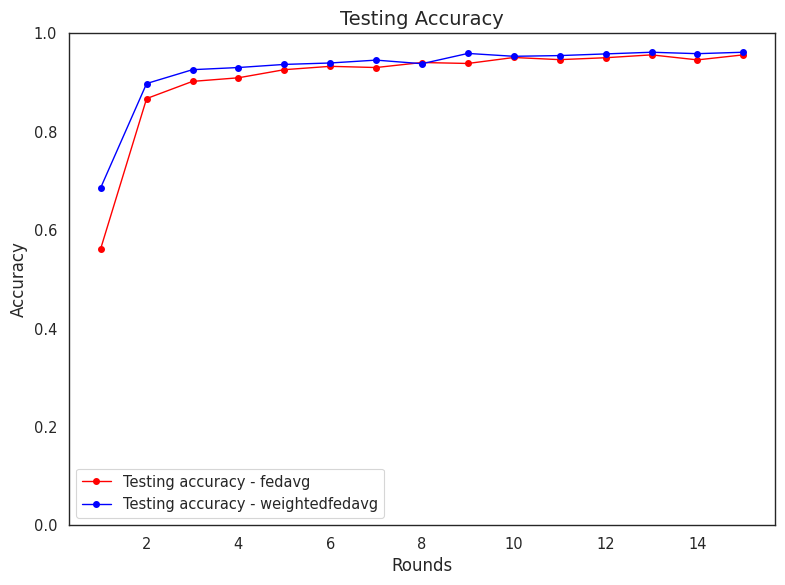

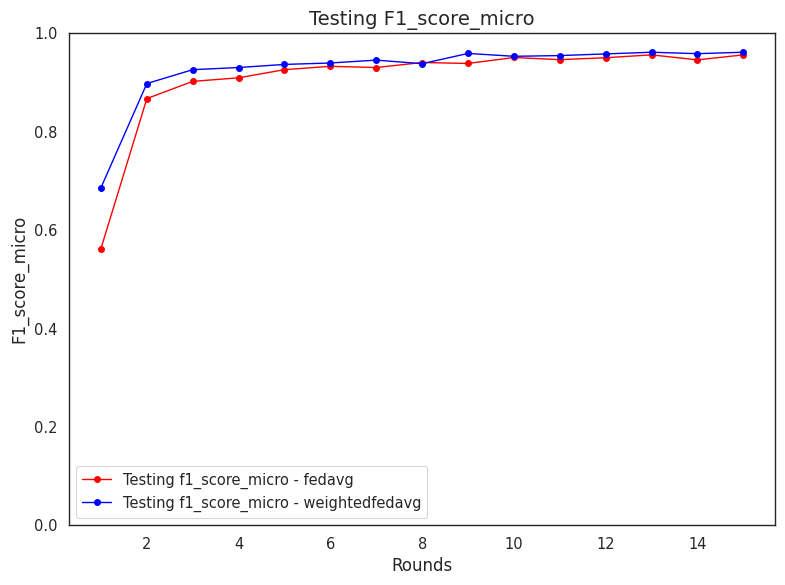

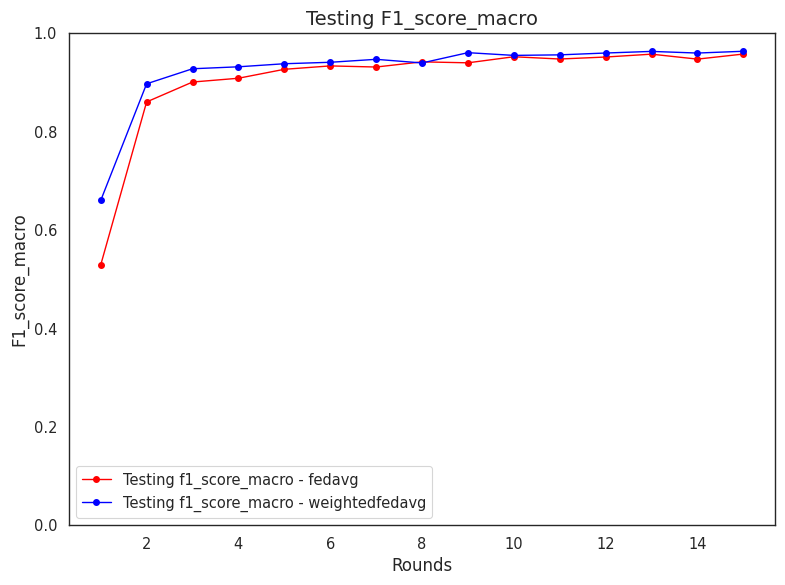

In [56]:
# List of metrics to plot
metrics_to_plot = ['accuracy', 'f1_score_micro', 'f1_score_macro']

# Iterate over each metric
for metric in metrics_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    for idx, (strategy, metrics) in enumerate(model_metrics.items()):
        metric_scores = metrics[metric]
        rounds = list(range(1, len(metric_scores) + 1))
        ax.plot(rounds, metric_scores, marker='o', markersize=4, linestyle='-', linewidth=1, color=palette[idx], label='Testing ' + metric + ' - ' + strategy)

    ax.set_ylim(bottom=0, top=1)  # Ensure the y-axis range is [0, 1]
    ax.set_title('Testing ' + metric.capitalize(), fontsize=14)
    ax.set_xlabel('Rounds', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}/fl_" + metric + "_over_strategies.png", dpi=300)
    plt.show()


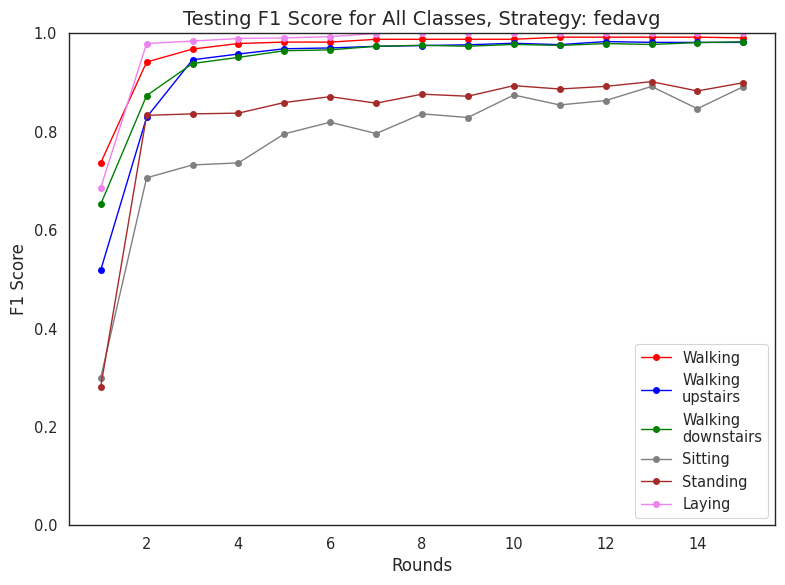

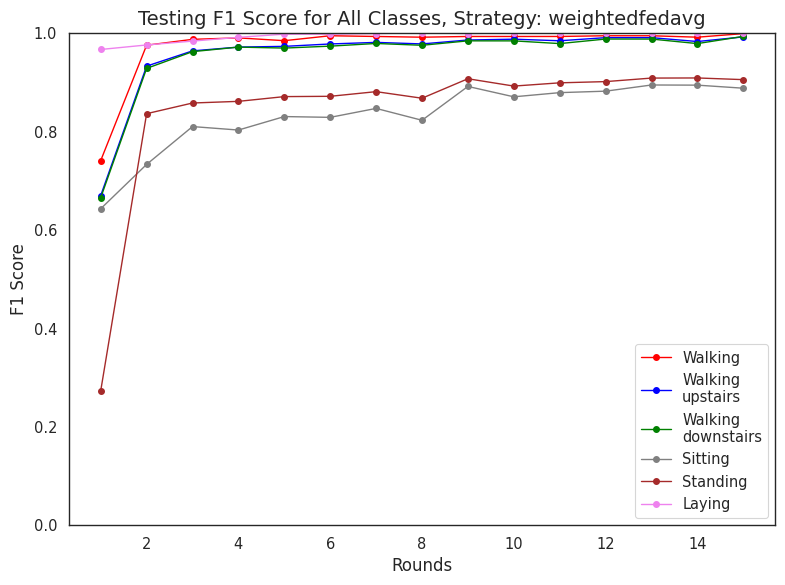

In [57]:
# Loop through each strategy
for strategy, metrics in model_metrics.items():

    # Get F1 scores per class
    f1_scores_perclass = metrics['f1_score_perclass']

    # Assume that f1_scores_perclass is a list of lists
    # where each sublist is a list of F1 scores for each class for a particular round
    num_classes = len(f1_scores_perclass[0])
    num_rounds = len(f1_scores_perclass)

    # Create rounds list
    rounds = list(range(1, num_rounds + 1))

    # Create a subplot for this strategy
    fig, ax = plt.subplots(figsize=(8, 6))

    # For each class
    for class_idx in range(num_classes):
        # Extract F1 scores for this class across all rounds
        class_f1_scores = [round_f1_scores[class_idx] for round_f1_scores in f1_scores_perclass]
        # Plot
        ax.plot(rounds, class_f1_scores, marker='o', markersize=4, linestyle='-', linewidth=1, color=palette[class_idx], label=class_names[class_idx])

    ax.set_ylim(bottom=0, top=1)
    ax.set_title(f'Testing F1 Score for All Classes, Strategy: {strategy}', fontsize=14)
    ax.set_xlabel('Rounds', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/fl_f1score_perclass_{strategy}.png", dpi=300)
    plt.show()


In [65]:
palette

['red', 'blue', 'green', 'grey', 'brown', 'violet', 'cyan']

In [66]:
strategies_acc_df = pd.DataFrame(strategies_acc, columns=[
    'Strategy',
    'Max Accuracy',
    'Last Accuracy',
    'Max F1 Score Micro',
    'Last F1 Score Micro',
    'Max F1 Score Macro',
    'Last F1 Score Macro'
])

# Create separate DataFrames for each metric
accuracy_df = strategies_acc_df[['Strategy', 'Max Accuracy', 'Last Accuracy']].melt(id_vars='Strategy', var_name='Metric', value_name='Accuracy')
f1_micro_df = strategies_acc_df[['Strategy', 'Max F1 Score Micro', 'Last F1 Score Micro']].melt(id_vars='Strategy', var_name='Metric', value_name='F1 Score')
f1_macro_df = strategies_acc_df[['Strategy', 'Max F1 Score Macro', 'Last F1 Score Macro']].melt(id_vars='Strategy', var_name='Metric', value_name='F1 Score')

# Plot accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x='Strategy', y='Accuracy', hue='Metric', data=accuracy_df, palette=palette, capsize=.1, errwidth=1)  # Added error bars

plt.ylim(0, 1)  # Set the y-axis range to be [0, 1]
plt.title('Comparison of Max and Last Accuracy Across Strategies')
plt.tight_layout()
plt.savefig(f"{save_path}/fl_accuracy_bar_over_strategies.png", dpi=300)
plt.show()

# Plot F1 Score Micro
plt.figure(figsize=(10, 5))
sns.barplot(x='Strategy', y='F1 Score', hue='Metric', data=f1_micro_df, palette=palette, capsize=.1, errwidth=1)  # Added error bars
plt.ylim(0, 1)  # Set the y-axis range to be [0, 1]
plt.title('Comparison of Max and Last Micro F1 Score Across Strategies')
plt.tight_layout()
plt.savefig(f"{save_path}/fl_f1score_micro_bar_over_strategies.png", dpi=300)
plt.show()

# Plot F1 Score Macro
plt.figure(figsize=(10, 5))
sns.barplot(x='Strategy', y='F1 Score', hue='Metric', data=f1_macro_df, palette=palette, capsize=.1, errwidth=1)  # Added error bars
plt.ylim(0, 1)  # Set the y-axis range to be [0, 1]
plt.title('Comparison of Max and Last Macro F1 Score Across Strategies')
plt.tight_layout()
plt.savefig(f"{save_path}/fl_f1score_macro_bar_over_strategies.png", dpi=300)
plt.show()




ValueError: ignored

<Figure size 1000x500 with 0 Axes>

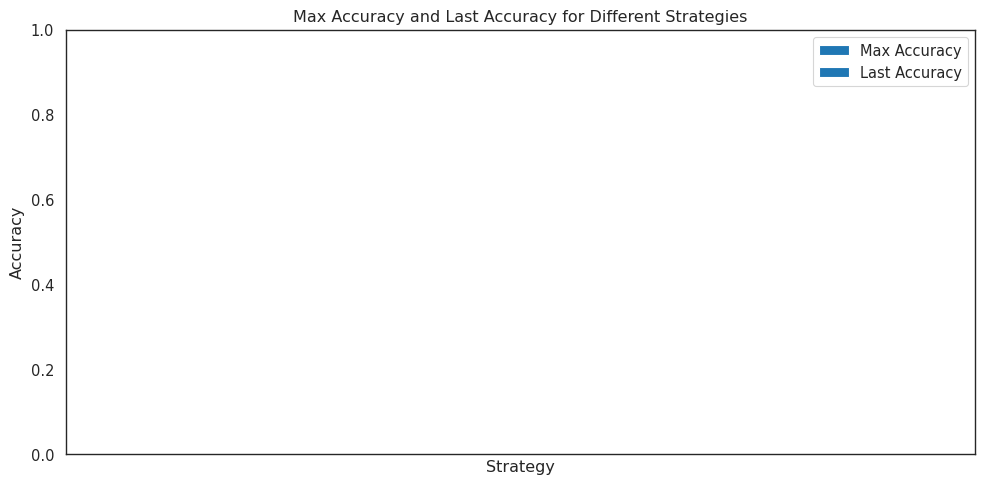

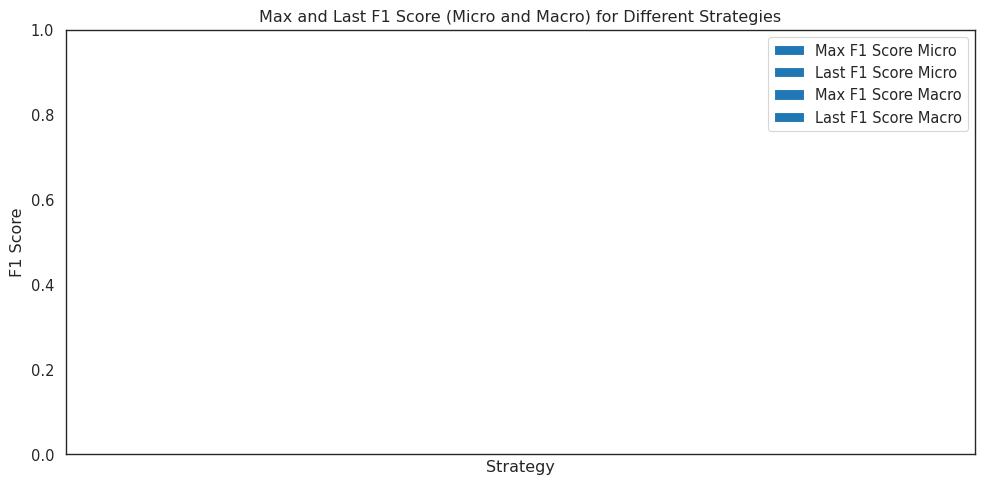

In [61]:
bar_width = 0.2  # adjust the bar width to fit more bars
r1 = np.arange(len(strategies_acc_df))
r2 = [x + bar_width for x in r1]
r3 = [x + 2*bar_width for x in r1]
r4 = [x + 3*bar_width for x in r1]

# Accuracy plot remains the same
plt.figure(figsize=(10, 5))
plt.bar(r1, strategies_acc_df['Max Accuracy'], width=bar_width, label='Max Accuracy')
plt.bar(r2, strategies_acc_df['Last Accuracy'], width=bar_width, label='Last Accuracy')
plt.xlabel('Strategy')
plt.ylabel('Accuracy')
plt.title('Max Accuracy and Last Accuracy for Different Strategies')
plt.xticks([r + bar_width / 2 for r in range(len(strategies_acc_df))], strategies_acc_df['Strategy'])
plt.legend()
plt.ylim(0, 1)  # Setting y-axis limit to [0, 1]
plt.tight_layout()
plt.savefig(f"{save_path}/fl_accuracy_bar_over_strategies.png", dpi=300)
plt.show()

# Updated F1 score plot
plt.figure(figsize=(10, 5))
plt.bar(r1, strategies_acc_df['Max F1 Score Micro'], width=bar_width, label='Max F1 Score Micro')
plt.bar(r2, strategies_acc_df['Last F1 Score Micro'], width=bar_width, label='Last F1 Score Micro')
plt.bar(r3, strategies_acc_df['Max F1 Score Macro'], width=bar_width, label='Max F1 Score Macro')
plt.bar(r4, strategies_acc_df['Last F1 Score Macro'], width=bar_width, label='Last F1 Score Macro')
plt.xlabel('Strategy')
plt.ylabel('F1 Score')
plt.title('Max and Last F1 Score (Micro and Macro) for Different Strategies')
plt.xticks([r + 1.5*bar_width for r in range(len(strategies_acc_df))], strategies_acc_df['Strategy'])
plt.legend()
plt.ylim(0, 1)  # Setting y-axis limit to [0, 1]
plt.tight_layout()
plt.savefig(f"{save_path}/fl_f1score_bar_over_strategies.png", dpi=300)
plt.show()


In [59]:
print("\n Plots and Models saved in "+save_path+" folder.")
print("Zipping...")
os.system('zip -r '+save_path+'.zip '+save_path)


 Plots and Models saved in f1761825 folder.
Zipping...


0

In [60]:
print(f"Elapsed time {timeit.default_timer()- start_global_time}")

Elapsed time 380.61367641100003
